<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_NLP_Project/blob/main/%5BNLP_02%5DUsing_SentencePiece.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 라이브러리 설치 및 import 

In [1]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash

--2022-09-23 03:28:38--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-09-23 03:28:38--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc375fb9eb3efd36f348c0cb9ea4.dl.dropboxusercontent.com/cd/0/get/BteAv95K0Np2RHjlAVPWdgJnDwsu2hwMJLMp62qzc3SyxOOBW5zCMyhc6EpsQ6TzNY7CuEbTgHilwW8U41Sd_BOPDG-ssBaTEP6de9e-xPT9CzRqcZTgKwipPvwohnfh_0cSpSFI4VP3lm5cQMnEGJDGEeswaaudZ16t8a_uRlZz43TKtjP1j6wYSnfrHLKd2SQ/file?dl=1# [following]
--2022-09-23 03:28:38--  https://uc375fb9eb3efd36f348c0cb9ea4.dl.dropboxusercontent.com/cd/0/get/BteAv95K0Np2

In [2]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!ls -l korean_spm*

-rw-r--r-- 1 root root 375119 Sep 23 03:21 korean_spm.model
-rw-r--r-- 1 root root 144477 Sep 23 03:21 korean_spm.vocab


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy
import matplotlib.pyplot as plt
import numpy as np
from konlpy.tag import Mecab
import sentencepiece as spm
import os
import urllib.request
import pandas as pd
from collections import Counter
mecab = Mecab()

## 2. 데이터 다운로드 및 분석

### 1) 데이터 다운로드

In [35]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")


train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [36]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


- map을 사용해서 str을 list에 담는다. : https://dojang.io/mod/page/view.php?id=2286

In [37]:
train_raw = list(map(str,train_data.document))
test_raw = list(map(str,test_data.document))

### 2) 분석

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


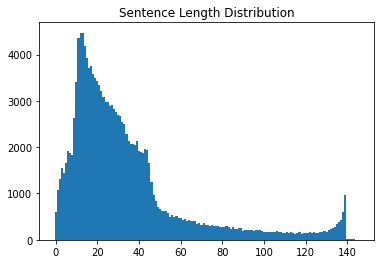

In [38]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(train_raw))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [39]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(train_raw, 1)

아
잼
1
4
4
굿
짱
휴
.
1
굿
음
?
?
ㅎ
굿
ㅋ
굿
즐
♥
굳
ㅋ
네
ㅎ
ㅋ
굿
ㅇ
k
.
굿
굿
굳
ㅠ
?
1
ㅋ
굿
쒯
굿
굿
굳
♬
굿
토
ㅋ
ㅋ
굿
ㅋ
굿
O
똥
ㅎ
.
굿
ㅎ
짱
굳
굿
굿
짱
?
z
굿
짱
음
굳
ㅇ
헐
굳
굳
굿
굿
굿
삼
꽝
굿
굿
굿
굿
ㅎ
굳
굿
4
!
?
ㅎ
1
굳
.
ㅎ
풉
아
굿
똥
ㅅ
왜
ㄴ
굳
쉣
봐
z


In [40]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 2000:
        print("Outlier Index:", idx+1)

Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40


In [41]:
check_sentence_with_length(train_raw, 12)

아햏햏 아햏햏 아햏햏.
단연 최고라고 할수있지
용가리 진짜짱짱맨이다ㅋ
나름 괜찮은 작품입니다
정말 실망 스러웟음..
무술인이 왜 총을드나?
너무너무 훈훈하네요^^
현실은 꿈, 꿈은 현실
답없네, 뭐하는건지..
엔딩이 넘 슬퍼요 :(
감동감동감동의 도가니탕
정말 최고의 영화...
진짜 짜증나는 영화..
상당히 재밌게 봤습니다
영상미가 역시 최고네요
감독ㅡㅡ다신영화찍지마라
이런 영화가 참 좋다.
정말 광해와 비슷한가?
더빙이 똥이야 ....
잠을 청할 수 있었다.
나오코 진짜 집중안된다
샬라샬라 나오다즁자쥬아
지루하다.. 지루해..
사과해요, 나한테!!!
소재가 굉장히 신선했다
솔직히 산만 하기만했다
OST가 좋은 영화!!
기적은 이미 일어났다.
답을 알려고 하지마라.
평점은 믿지마셈 재밌음
재미 드럽게 없다ㅋㅋㅋ
자식을 그렇게 때리냐?
감동적이였고 좋았습니다
울컥하는 사회현실 ㅠㅠ
등장인물들 모두 짱~~
막장드라마가 따로없구만
말 필요엄따~~~~진정
꿀잼 영화 추억이다ㅜㅜ
맞추자 ㅍ?차븟ㅇㄱ디시
순수하고 아름답다 :)
변태적 성욕 자기합리화
흠....나름 갠찬네요
걍 10점 이라길래..
실력이 필요없는 상황.
감동과 웃음을 한방에!
이거야 이거 ㅋㅋㅋㅋㅋ
성동일딸 시르다...참
평점알바들을 위해 1점
볼만합니다 강추!!ㅋㅋ
이거말고 겨울왕국을봐라
좋은니다..^.,^~~
2.3 (10자 제한)
아무도 안달았네..ㄷㄷ
엉성하고 어설프고...
그냥 보통으로 보았다.
너무 슬픈영화..울음ㅠ
으리는 개뿔 ㅡ,.ㅡ^
처음 본 에로 영화..
평점 조정을 위해...
그냥 쓰레기지 쓰레기~
쵝오네요 최고 대박영화
유전무죄 무전유죄!!!
의외의 꿀잼 이였습니다
어차피 우승은 송민호~
이 때부터가 쓰레기였지
완전 찝찝한 영화...
이상형이 바뀌었습니다.
역시 산드라블록 누님!
결국 엄마가 죽인거네?
그냥 그저 별시리...
추천할만한 경제영화였음
제대로 알아야할 역사임
일본판이더재미있음...
역시 재미있군요 >ㅁ<
아깝다 나의 1점도ㅡㅡ
마음이 따뜻해지는 영화
죽었다. 참 재미없다.

Data Size: 146183
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


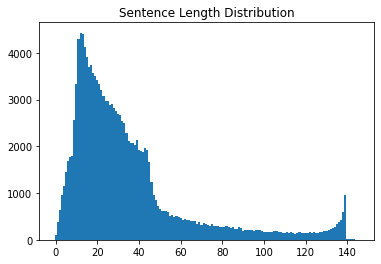

In [42]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(train_raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


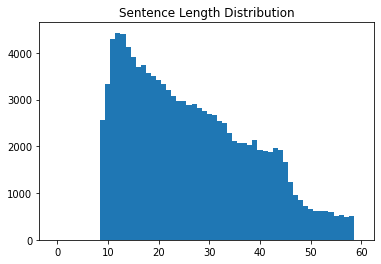

In [43]:
max_len = 60
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [44]:
temp_file = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/sp_tokenizer/data/ratings_train.txt.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.



In [45]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다락방에도들어가신다람쥐.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
# enable_size가 True이면 "nbest_size > 1" 또는 "nbest_size = -1"을 지정해야 합니다. 
#'알파'와 '알파'. "nbest_size"는 BPE-드롭아웃에서 무시된 유니그램 모드에서만 활성화됩니다. ' 
# nbest_size = -1"일 때, 이 방법은 격자에 있는 모든 후보로부터 표본을 추출한다. 'nbest 분할의 결과입니다.
print(s.SampleEncodeAsPieces('아버지가방에들어가신다락방에도들어가신다람쥐.',2,0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1682, 10, 406, 15, 1396, 10, 156, 16, 858, 406, 1008, 1396, 10, 156, 16, 2251, 3506, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '락', '방', '에', '도', '들어', '가', '신', '다', '람', '쥐', '.']
아버지가방에들어가신다락방에도들어가신다람쥐.


In [46]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre')

    return tensor, word_index, index_word

In [47]:
#train_tensor, train_word_to_index, train_index_to_word = sp_tokenize(s, list(map(str,train_data['document'])))
#print(train_tensor)

In [48]:
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 

    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    X_train, word_index, index_word = sp_tokenize(s,list(map(str,train_data['document']))) # 토큰화

    X_test, word_index, index_word = sp_tokenize(s,list(map(str,test_data['document']))) # 토큰화

        
    return np.array(list(X_train)), np.array(list(train_data['label'])), np.array(list(X_test)), np.array(list(test_data['label']))
    
X_train, y_train, X_test, y_test= load_data(train_data, test_data)

In [49]:
# validation set 10000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(X_val.shape)
print(y_val.shape)

(96182, 133)
(96182,)
(50000, 133)
(50000,)


In [50]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


## 4.SentencePiece 모델 학습

## 5. Tokenizer 함수 작성

## 6. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

네이버 영화리뷰 감정 분석 태스크가 있습니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요.

만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요.

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

중복제거 넘 값 제거

In [51]:
vocab_size = 8000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 60  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(16))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(16, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 60)          480000    
                                                                 
 lstm_2 (LSTM)               (None, 16)                4928      
                                                                 
 dense_4 (Dense)             (None, 16)                272       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 485,217
Trainable params: 485,217
Non-trainable params: 0
_________________________________________________________________


In [52]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [53]:

              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 5s 19ms/step - loss: 0.5227 - accuracy: 0.7505 - val_loss: 0.3676 - val_accuracy: 0.8453
Epoch 2/20
188/188 [==============================] - 3s 17ms/step - loss: 0.3398 - accuracy: 0.8582 - val_loss: 0.3486 - val_accuracy: 0.8527
Epoch 3/20
188/188 [==============================] - 3s 17ms/step - loss: 0.3118 - accuracy: 0.8712 - val_loss: 0.3457 - val_accuracy: 0.8529
Epoch 4/20
188/188 [==============================] - 3s 17ms/step - loss: 0.2930 - accuracy: 0.8795 - val_loss: 0.3493 - val_accuracy: 0.8512
Epoch 5/20
188/188 [==============================] - 3s 17ms/step - loss: 0.2748 - accuracy: 0.8885 - val_loss: 0.3486 - val_accuracy: 0.8524
Epoch 6/20
188/188 [==============================] - 3s 17ms/step - loss: 0.2567 - accuracy: 0.8964 - val_loss: 0.3585 - val_accuracy: 0.8499
Epoch 7/20
188/188 [==============================] - 3s 17ms/step - loss: 0.2386 - accuracy: 0.9046 - val_loss: 0.3724 - val_accuracy: 0.8491

In [54]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.9418 - accuracy: 0.8176 - 7s/epoch - 4ms/step
[0.9417999982833862, 0.8176251649856567]


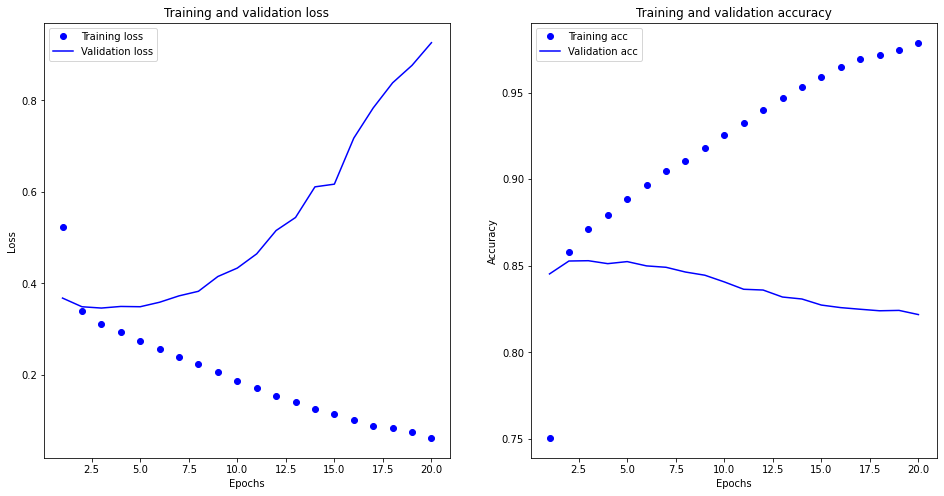

In [56]:
history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

f, ax = plt.subplots(1,2,figsize=(16,8))

# "bo"는 "파란색 점"입니다
ax[0].plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
ax[0].plot(epochs, val_loss, 'b', label='Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()


ax[1].plot(epochs, acc, 'bo', label='Training acc')
ax[1].plot(epochs, val_acc, 'b', label='Validation acc')
ax[1].set_title('Training and validation accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.show()